In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_gp
import ariel_load
import ariel_numerics
import time
import numpy as np
import cupy as cp
import multiprocess
from tqdm import tqdm
import scipy
import copy
import matplotlib.pyplot as plt

local


In [2]:
train_data = kgs.load_all_train_data()
train_data = train_data[:750]
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
kgs.sanity_checks_active = True
model.train(train_data)

In [3]:
loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')

In [4]:
model.infer(train_data[0:1]);

In [5]:
for d,r in tqdm(zip(train_data,loaded_res)):
    mm= copy.deepcopy(model.results['model_mean'])
    mm= copy.deepcopy(model.results['model_mean'])
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
    mm.set_parameters(r[0])
    mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
    obs_transit = copy.deepcopy(model.results['obs'])
    
    stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
    transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    obs_transit.labels = stellar_labels*transit_labels
    #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
    #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
    d.diagnostics['transit'] = obs_transit
del loaded_res
del mm
del model

750it [02:22,  5.27it/s]


In [6]:
#S,components,weights = kgs.dill_load(kgs.temp_dir + '/explore_bad_pixels_pca.pickle')

In [7]:
res = kgs.dill_load(kgs.temp_dir+'/explore_base_shape_from_pca.pickle')

In [15]:
xx=[]
for i_wavelength in tqdm(range(283)):
    if i_wavelength==0:
        transit_combined = np.concatenate([d.diagnostics['transit'].export_matrix(False)[:,0] for d in train_data])
    else:
        transit_combined = np.concatenate([d.diagnostics['transit'].export_matrix(True)[:,i_wavelength-1] for d in train_data])
    coeffs = cp.concatenate([cp.array(r[i_wavelength]) for r in res],1)
    residual = []
    coeffs2_list = []
    for ii in range(1,coeffs.shape[0]+1):
        X = coeffs[:ii,:]
        coeffs2, _, _, _ = cp.linalg.lstsq(X.T, cp.array(transit_combined), rcond=None)  # coefs shape: (2, M)
        pred = coeffs2@X
        residual.append(kgs.rms(pred-cp.array(transit_combined)).get())
        coeffs2_list.append(coeffs2)
    
    X = cp.stack((cp.array(transit_combined), 0*cp.array(transit_combined)+1))
    coeffs3,_,_,_= cp.linalg.lstsq(X.T, coeffs.T, rcond=None)

    xx.append((residual, coeffs2_list, coeffs3[0,:]))

kgs.dill_save(kgs.temp_dir+'/explore_base_shape_from_pca_coeff_list.pickle', xx)

100%|█████████████████████████████████████████████████████████████████████████████████| 283/283 [04:18<00:00,  1.09it/s]


In [12]:
coeffs3.shape

(2, 5)

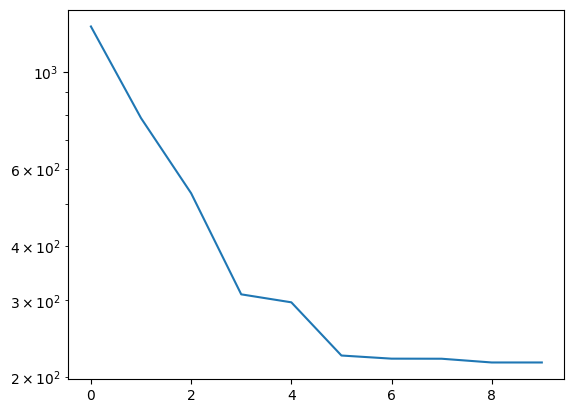

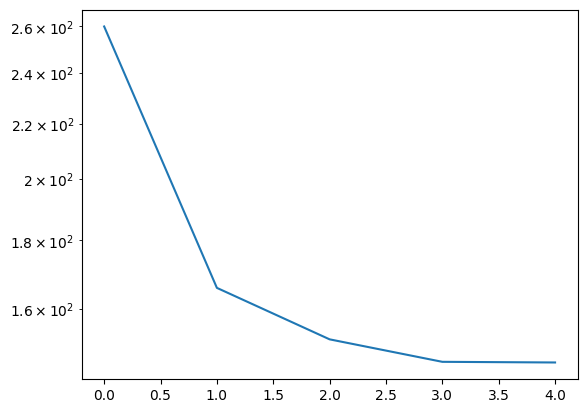

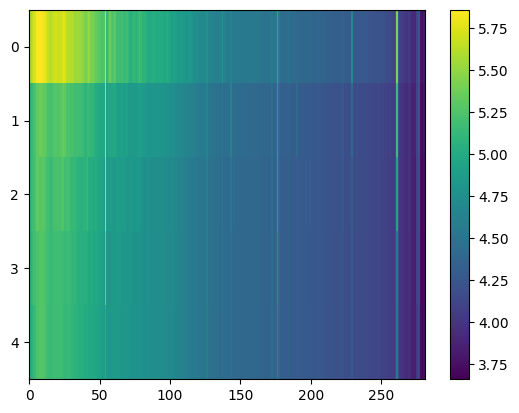

In [23]:
plt.figure()
plt.semilogy(xx[0][0])
plt.figure()
plt.semilogy(xx[1][0])
plt.figure()
plt.imshow(np.log(np.array([x[0] for x in xx[1:]]).T), aspect='auto', interpolation='none')
plt.colorbar()

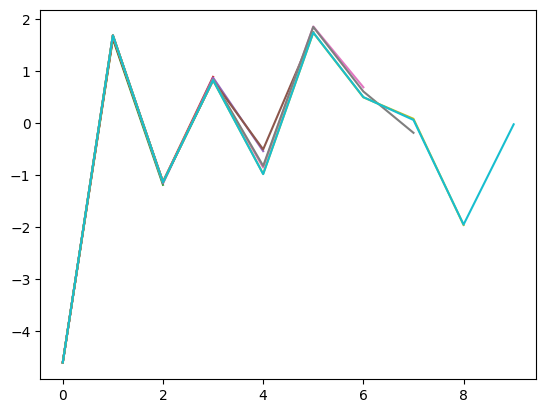

In [37]:
plt.figure()
for ii in range(10):
    plt.plot(xx[0][1][ii].get())

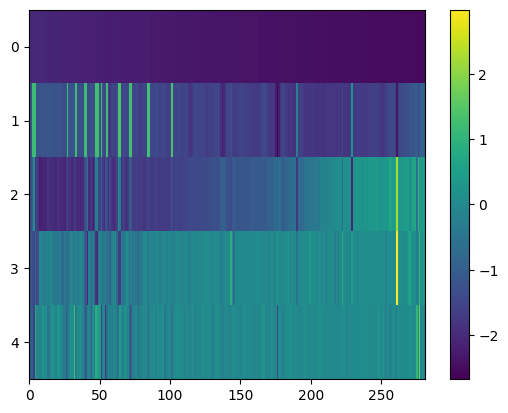

In [57]:
plt.figure()
XX = np.array([x[1][-1].get() for x in xx[1:]]).T
#XX = XX*np.sign(XX[1,:])
plt.imshow(XX, aspect='auto', interpolation='none')
plt.colorbar()

In [55]:
XX.shape

(5, 282)

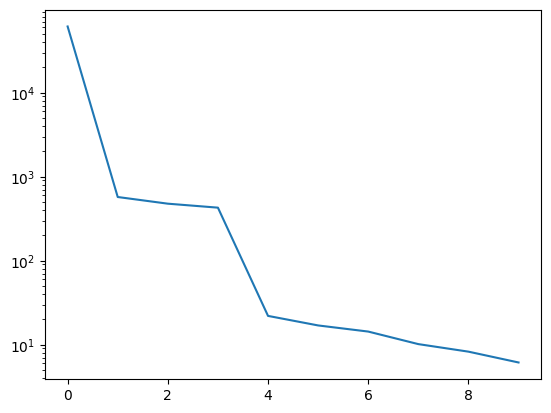

In [36]:
plt.semilogy([kgs.rms(w).get() for w in weights[0]])

In [33]:
len(weights[0])

10